# ENSO analysis using 20CRv3 and CMIP6 data
This notebook calculates and plots the NINO3.4 index using monthly sea surface temperature anomalies using CMIP6 historical model output (43 models) and 20CRv3 reanalysis data (79 members).  

Notebook last updated on 2 June 2023 by Kate Bongiovanni.

In [1]:
# import relevant libraries
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap 
import dask.diagnostics # to check how long something is taking to load

In [2]:
# define path for files
path = '/g/data/w40/W48_GDATA_MOVED/kb6999'
# add path to save figures
fig_path = '/g/data/w40/W48_GDATA_MOVED/kb6999/Masters_paper/FIGURES'

In [3]:
import sys 
sys.path.append(f'{path}/Masters_paper') 
# import custom functions
import GRL_functions as func

In [4]:
# store each section of the CMIP6 model directory
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
ts_dir = '/historical/r1i1p1f1/Amon/ts/gr1.5/'
print(institution_dir, tas_dir, pr_dir, ts_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/ /historical/r1i1p1f1/Amon/ts/gr1.5/


## Read in model data

In [5]:
# use read_models() function to read in monthly model data from 1850-2015
models_ts = func.read_models(institution_dir, ts_dir, '1850-01','2015-01')

54 model paths found and loaded into the dictionary "models"
54 models have been successfully loaded into an xarray


model 'AWI-CM-1-1-MR' is no longer available

In [6]:
# select out the 43 models that were available at the time minus one model which is no longer available
models = models_ts.sel(model= ['ACCESS-CM2','ACCESS-ESM1-5','AWI-ESM-1-1-LR','BCC-CSM2-MR','BCC-ESM1',
                             'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 
                             'CMCC-CM2-HR4', 'CMCC-CM2-SR5' ,'CanESM5', 'E3SM-1-1' ,'E3SM-1-1-ECA' ,'EC-Earth3', 
                             'EC-Earth3-AerChem' , 'EC-Earth3-Veg-LR', 'FGOALS-f3-L' ,'FGOALS-g3', 'FIO-ESM-2-0', 
                             'GFDL-CM4' ,'GFDL-ESM4', 'GISS-E2-1-G' ,'GISS-E2-1-G-CC', 'GISS-E2-1-H' ,'IITM-ESM', 
                             'INM-CM4-8', 'INM-CM5-0' ,'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6' ,'MPI-ESM-1-2-HAM',
                             'MPI-ESM1-2-LR' ,'MRI-ESM2-0', 'NESM3', 'NorCPM1' ,'NorESM2-LM', 'NorESM2-MM',
                             'SAM0-UNICON', 'TaiESM1'])
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 42 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-ESM-1-1-LR' 'BCC-CSM2-MR' 'BCC-ESM1'
 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2' 'CESM2-WACCM'
 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5' 'E3SM-1-1'
 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem' 'EC-Earth3-Veg-LR'
 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4' 'GFDL-ESM4'
 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM' 'INM-CM4-8'
 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6' 'MPI-ESM-1-2-HAM'
 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1' 'NorESM2-LM' 'NorESM2-MM'
 'SAM0-UNICON' 'TaiESM1']


In [7]:
# area weighting 
models_w = models*np.cos(models_ts.lat*(np.pi/180))

In [8]:
# calculate the multi-model mean
mmm = models_w.mean(dim='model')

## Read in 20CR data

In [9]:
# create a list of member names excluding member 70 cos that file is problematic 
members = [*range(1,70),*range(71,81)]

In [10]:
# read in raw 20CR temperature data
tmp_paths = [f"{path}/Reanalysis/20CR_TMP_raw_members/R_raw_Glob_TMP{m:02d}.nc" for m in members]
ds_tmp = xr.open_mfdataset(tmp_paths, combine='nested', concat_dim='member', chunks={'time': 100})
ds_tmp.coords['member'] = members

In [11]:
# rename the temperature variable
reanal_r = xr.Dataset({'tmp': ds_tmp.TMP})
# convert into degrees Celsius
reanal_r['tmp'] = reanal_r.tmp-273

In [12]:
# reverse the latitude axis so it goes from -90 to 90
reanal = reanal_r.reindex(lat=list(reversed(reanal_r.lat)))

In [13]:
# area weighting 
reanal_w = reanal*np.cos(reanal.lat*(np.pi/180))

In [14]:
# select out the years around the Krakatau eruption plus climatology
reanal_w = reanal_w.sel(time=slice('1850-01', '1899-01'))

In [15]:
# use functions to calculate the seasonal anomalies for the globe
R_monthly_anom_glob = func.monthly_anomaly(reanal_w, '1850-01', '1879-12')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 50 times more chunks
  return self.array[key]


In [16]:
# take the multi-member mean
R_em_mon_Glob = R_monthly_anom_glob.mean(dim=('member'))

## Calculate NINO3.4 index

In [17]:
# calculate the nino3.4 index for 20CR ensemble mean for every month divided by std
R_nino34 = func.nino34(R_em_mon_Glob.tmp, '1850-01', '1879-12', 1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 50 times more chunks
  return self.array[key]


In [18]:
# calculate the nino3.4 index for multi-model mean for every month divided by std
Mmm_nino34 = func.nino34(mmm, '1850-01', '1879-12', 1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


In [19]:
# calculate the nino3.4 index for all models for every month divided by std
M_nino34 = func.nino34(models_w, '1850-01', '1879-12', 1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


In [20]:
# save global anomalies into a netcdf
file_path = f'{path}/Masters_paper/NINO3.4_index/'
# if they have already been saved as a netcdf, then nothing happens here
with dask.diagnostics.ProgressBar():
    if not os.path.exists(f'{file_path}Mmm_nino34.nc'):
        Mmm_nino34.to_netcdf(f'{file_path}Mmm_nino34.nc')
    if not os.path.exists(f'{file_path}M_nino34.nc'):
        M_nino34.to_netcdf(f'{file_path}M_nino34.nc')
    if not os.path.exists(f'{file_path}R_nino34.nc'):
        R_nino34.to_netcdf(f'{file_path}R_nino34.nc')
        print('nino34 files saved')

In [21]:
# open the newly saved anomalies
Mmm_nino34 = xr.open_dataset(f'{file_path}Mmm_nino34.nc')
M_nino34 = xr.open_dataset(f'{file_path}M_nino34.nc')
R_nino34 = xr.open_dataset(f'{file_path}R_nino34.nc')

### Threshold

In [22]:
# set the threshold for el nino/la nina events
THOLD = 0.4

# Graphs

In [23]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [24]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [25]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

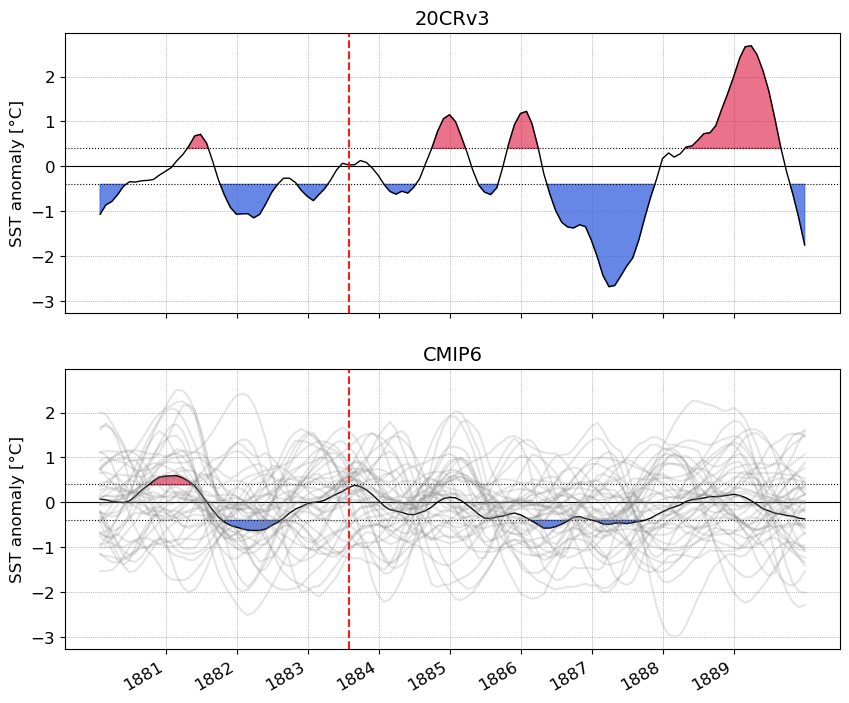

In [26]:
# plot time series of nino3.4 index for CMIP6 and 20CR data
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,8))

with dask.diagnostics.ProgressBar():
    # plot the 20CRv3 ensemble mean
    func.nino34_plot(R_nino34.tmp.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes[0])
    # plot the CMIP6 multi-member mean
    func.nino34_plot(Mmm_nino34.ts.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes[1])
    # plot each model member
    for m, model in enumerate(M_nino34.model):
        M_nino34.ts.sel(model=model).sel(time=slice('1880-01','1889-12')).plot(ax = axes[1], color='gray', 
                alpha = 0.2)

# set the axis labels and title
axes[0].set(ylabel= f'SST anomaly [{deg}C]', title = '20CRv3') 
axes[1].set(ylabel= f'SST anomaly [{deg}C]', title = 'CMIP6', xlabel=None)

plt.savefig(f'{fig_path}/RM_nino34_index_all_mods_1880-1890.pdf', dpi=300, bbox_inches='tight')